# Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import cv2
from transformers import LlavaNextProcessor, AutoProcessor, LlavaNextForConditionalGeneration, Kosmos2ForConditionalGeneration
import torch
from torchvision.transforms import v2
import tqdm
from PIL import Image
import random

In [2]:
device = torch.device('cpu')

In [17]:
device = torch.device('cuda:0')

In [2]:
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0
device = torch.device('mps') # For MAC

# 2D Image Generation

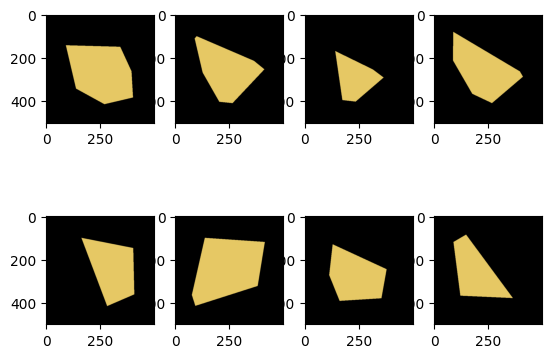

In [3]:
N = 20
size = 500

images = []
for i in range(N):
    points = np.random.rand(7, 2) * size / np.sqrt(2) - size / (2 * np.sqrt(2)) + size / 2
    hull = ConvexHull(points)
    points = points[hull.vertices]
    points = points.astype(int)

    canvas = np.zeros((size, size, 3)) * 255
    canvas = cv2.fillPoly(canvas, [points], (230, 200, 100))
    images.append(canvas)

images = np.array(images)

nrow = 2
ncol = 4

_, axarr = plt.subplots(nrow, ncol)

for i in range(nrow):
    for j in range(ncol):
        axarr[i, j].imshow(images[i * ncol + j].astype(int))

plt.show()

# Rotation

100%|██████████| 20/20 [00:00<00:00, 23.40it/s]


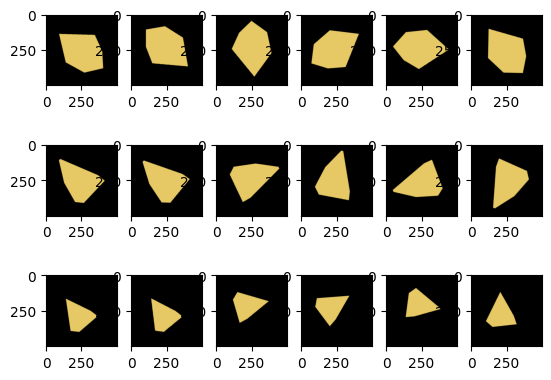

In [4]:
n_perspective = 5

new_images = []

transform = v2.RandomRotation(degrees=180)

for i in tqdm.tqdm(range(len(images))):
    warped_images = []
    for j in range(n_perspective):
        warped_image = transform(torch.from_numpy(images[i]).permute(2, 0, 1)).permute(1, 2, 0).numpy()
        # warped_image = images[i]
        warped_images.append(warped_image)
    new_images.append(warped_images)

new_images = np.array(new_images)

nrow = 3
ncol = 5 + 1

_, axarr = plt.subplots(nrow, ncol)

for i in range(nrow):
    axarr[i, 0].imshow(images[i].astype(int))
    for j in range(1, ncol):
        axarr[i, j].imshow(new_images[i, j-1].astype(int))

# Models

### LLaVA

In [6]:
llava_model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf").to(device)
llava_processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
llava_model.generation_config.pad_token_id = llava_model.generation_config.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### KOSMOS-2

In [ ]:
kosmos_model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224").to(device)
kosmos_processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

# Type 1 Error

### Positive Pair Dataset

100%|██████████| 20/20 [00:01<00:00, 17.75it/s]


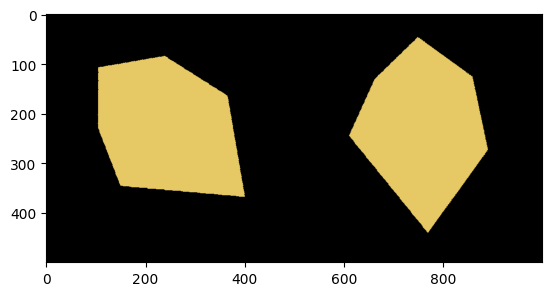

In [7]:
positive_pairs = []

for i in tqdm.tqdm(range(len(images))):
    for j in range(n_perspective):
        for k in range(n_perspective):
            if j == k:
                continue
            positive_pairs.append(np.concat((new_images[i, j], new_images[i, k]), axis=1))

positive_pairs = np.array(positive_pairs)

plt.imshow(positive_pairs[0].astype(int))
plt.show()

### Test on LLaVA

In [8]:
prompt = '''
[INST] <image>\n
USER:
There are two 2D yellow shapes.
Two shapes may or may not be congruent. Are they congruent?
Answer in yes or no (only in a single word, without period)
[/INST]
'''

error = 0

with torch.no_grad():
    # for i in tqdm.tqdm(range(len(positive_pairs))):
    for i in tqdm.tqdm(range(10)):
        image = positive_pairs[i].astype(np.uint8)
        image = Image.fromarray(image)

        inputs = llava_processor(text=prompt, images=image, return_tensors='pt').to(device)

        generated_ids = llava_model.generate(**inputs, max_new_tokens=64)
        generated_text = llava_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        ans = generated_text.split()[-1]

        if ans.lower() != 'yes':
            error += 1

llava_type1_error = error / 10
print(llava_type1_error)

100%|██████████| 10/10 [59:18<00:00, 355.88s/it]

0.1


### Test on KOSMOS-2

In [12]:
prompt = '''
USER:
There are two 2D yellow shapes.
Two shapes may or may not be congruent. Are they congruent?
Answer in yes or no (only in a single word, without period)

ASSISTANT:
'''

error = 0

for i in tqdm.tqdm(range(len(positive_pairs))):
    image = positive_pairs[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = kosmos_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = kosmos_model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = kosmos_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = kosmos_processor.post_process_generation(generated_text, cleanup_and_extract=False)

    ans = processed_text.split()[-1]

    if ans.lower() != 'yes':
        error += 1

kosmos_type1_error = error / len(positive_pairs)
print(kosmos_type1_error)

100%|██████████| 400/400 [04:35<00:00,  1.45it/s]

0.0


# Type 2 Error

### Negative Pair Dataset

100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


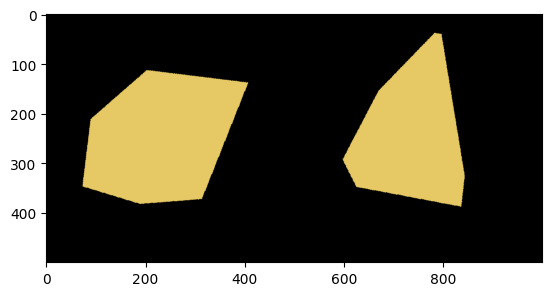

In [9]:
negative_pairs = []

for i in tqdm.tqdm(range(len(images))):
    for j in range(len(images)):
        if i == j:
            continue
        n1 = np.random.randint(0, n_perspective)
        n2 = np.random.randint(0, n_perspective)
        negative_pairs.append(np.concat((new_images[i, n1], new_images[j, n2]), axis=1))

negative_pairs = np.array(negative_pairs)

plt.imshow(negative_pairs[0].astype(int))
plt.show()

### Test on LLaVA

In [10]:
prompt = '''
[INST] <image>\n
USER:
There are two 2D yellow shapes.
Two shapes may or may not be congruent. Are they congruent?
Answer in yes or no (only in a single word, without period)
[/INST]
'''

error = 0

for i in tqdm.tqdm(range(10)):
    image = negative_pairs[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = llava_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = llava_model.generate(**inputs, max_new_tokens=64)
    generated_text = llava_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    ans = generated_text.split()[-1]

    if ans.lower() != 'no':
        error += 1

llava_type2_error = error / 10
print(llava_type2_error)

100%|██████████| 10/10 [1:22:37<00:00, 495.78s/it]

0.9


### Test on KOSMOS-2

In [14]:
prompt = '''
USER:
There are two 2D blue shapes.
Two shapes may or may not be congruent. Are they congruent?
Answer in yes or no (only in a single word, without period)

ASSISTANT:
'''

error = 0

for i in tqdm.tqdm(range(len(negative_pairs))):
    image = negative_pairs[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = kosmos_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = kosmos_model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = kosmos_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = kosmos_processor.post_process_generation(generated_text, cleanup_and_extract=False)

    ans = processed_text.split()[-1]

    if ans.lower() != 'no':
        error += 1

kosmos_type2_error = error / len(negative_pairs)
print(kosmos_type2_error)

100%|██████████| 380/380 [03:58<00:00,  1.59it/s]

1.0


# Multiple Choice

### Question Dataset

100%|██████████| 20/20 [00:01<00:00, 15.03it/s]


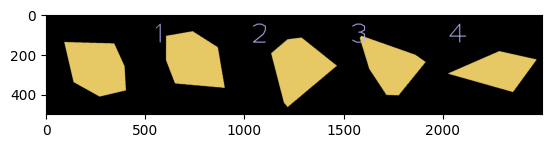

answer: 1


In [11]:

im = cv2.putText(new_images[0, 0].copy(), "2", (5, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (100, 100, 200), 2, cv2.LINE_AA)
plt.imshow(im.astype(int))
plt.plot()

questions = []
answers = []

for i in tqdm.tqdm(range(len(images))):
    original = images[i]
    composite = original.copy()
    
    indices = set(range(len(images)))
    indices.discard(i)
    indices = random.sample(list(indices), k=3)
    indices.append(i)
    random.shuffle(indices)

    for num, j in enumerate(indices):
        k = np.random.randint(0, len(new_images[j]))
        im = cv2.putText(new_images[j, k].copy(), str(num+1), (25, 150), cv2.FONT_HERSHEY_PLAIN, 10, (180, 180, 250), 4, cv2.LINE_AA)
        composite = np.concat((composite, im), axis=1)

    questions.append(composite)
    answers.append(indices.index(i) + 1)

questions = np.array(questions)
plt.imshow(questions[0].astype(int))
plt.show()
print(f'answer: {answers[0]}')

### Test on LLaVA

In [16]:
prompt = '''
[INST] <image>\n
There are five shapes, one (leftmost) without index and four with index.
Among four of the shapes with number indices, only one is the same with the leftmost shape without index.
Choose the number that is congruent to the leftmost image.
You should answer only in number (single word without period).
[/INST]
'''

correct = 0

for i in tqdm.tqdm(range(10)):
    image = questions[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = llava_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = llava_model.generate(**inputs, max_new_tokens=64)
    generated_text = llava_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    ans = generated_text.split()[-1]
    print(ans)

    if ans == str(answers[i]):
        correct += 1

print(correct / 10)

 10%|█         | 1/10 [05:47<52:07, 347.45s/it]

1


 20%|██        | 2/10 [11:46<47:15, 354.45s/it]

1


 30%|███       | 3/10 [17:39<41:14, 353.45s/it]

1


 40%|████      | 4/10 [23:33<35:24, 354.02s/it]

1


 50%|█████     | 5/10 [29:28<29:31, 354.23s/it]

1


### Test on KOSMOS-2

In [27]:
prompt = '''
Question:
There are five shapes, one (leftmost) without index and four with index.
Among four of the shapes with number indices, only one is the same with the leftmost shape without index.
Choose the number that is congruent to the leftmost image.
You should answer only in number (single word without period).

Answer:
'''

correct = 0

for i in tqdm.tqdm(range(len(questions))):
    image = questions[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = kosmos_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = kosmos_model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = kosmos_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = kosmos_processor.post_process_generation(generated_text, cleanup_and_extract=False)

    ans = processed_text.split()[-1]

    if ans == str(answers[i]):
        correct += 1

print(correct / len(questions))

100%|██████████| 20/20 [00:33<00:00,  1.68s/it]

0.25
